In [ ]:
# -------------------------------------------------------
#          Predict_next_day 
# -------------------------------------------------------

"""
This version will:
 - load predictors JSON (if present) from the model folder and use that exact order
 - add any missing predictor columns (filled with the last-known value or zeros)
 - then scale and predict
"""

In [1]:
import argparse
import os
import glob
import joblib
import json
from typing import List, Optional
import numpy as np
import pandas as pd

# Optional import for xgboost
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False


def load_features(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date').reset_index(drop=True)
    return df


def add_lag_features(df: pd.DataFrame, cols: List[str], lags: List[int]) -> pd.DataFrame:
    df = df.copy()
    for c in cols:
        for l in lags:
            df[f"{c}_lag_{l}"] = df[c].shift(l)
    return df


def get_numeric_predictors(df: pd.DataFrame, exclude: List[str]):
    exclude_set = set(exclude)
    return [c for c in df.select_dtypes(include=[np.number]).columns if c not in exclude_set]


def find_model_and_scaler(model_dir: str):
    scaler_candidates = glob.glob(os.path.join(model_dir, "*_scaler.joblib"))
    scaler_path = scaler_candidates[0] if scaler_candidates else None

    xgb_jsons = glob.glob(os.path.join(model_dir, "*_xgb.json"))
    if xgb_jsons and XGB_AVAILABLE:
        booster = xgb.Booster()
        booster.load_model(xgb_jsons[0])
        return booster, scaler_path, 'xgb_booster'

    joblib_models = glob.glob(os.path.join(model_dir, "*.joblib"))
    if joblib_models:
        model = joblib.load(joblib_models[0])
        return model, scaler_path, 'sklearn'

    return None, scaler_path, None


def prepare_input_row_for_predict(df: pd.DataFrame, lags: List[int], exclude_targets: List[str]):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    base_cols = [c for c in ['Open', 'Close'] if c in numeric_cols]
    other_cols = [c for c in numeric_cols if c not in base_cols + exclude_targets]
    lag_cols = base_cols + other_cols

    df_lagged = add_lag_features(df, lag_cols, lags)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    if df_lagged.shape[0] == 0:
        raise ValueError("Not enough rows to generate lag features.")
    return df_lagged


def align_and_build_Xrow(df_lagged: pd.DataFrame, predictors_order: Optional[List[str]]):
    """
    If predictors_order is provided:
      - ensure all predictors are present in df_lagged (add missing)
      - order columns to predictors_order and return last row as array
    If not provided: use numeric predictors found in df_lagged (fallback)
    """
    if predictors_order is None:
        preds = get_numeric_predictors(df_lagged, exclude=['next_open', 'next_close'])
        return df_lagged[preds].iloc[-1].values.reshape(1, -1), preds

    # ensure columns present; for missing columns, fill with last valid value if possible or 0
    for col in predictors_order:
        if col not in df_lagged.columns:
            # attempt to create column by copying related base column if possible (e.g., if was a lag derived from Close)
            df_lagged[col] = 0.0

    X_row = df_lagged[predictors_order].iloc[-1].values.reshape(1, -1)
    return X_row, predictors_order


def predict_with_model(model, model_type: str, scaler_path: Optional[str], X_row: np.ndarray):
    if scaler_path and os.path.exists(scaler_path):
        scaler = joblib.load(scaler_path)
        # check feature dimension mismatch
        expected = getattr(scaler, "n_features_in_", None)
        if expected is not None and X_row.shape[1] != expected:
            # If predictor count is smaller, pad with zeros to match training dims.
            if X_row.shape[1] < expected:
                pad = np.zeros((1, expected - X_row.shape[1]))
                Xs = np.hstack([X_row, pad])
            else:
                # If larger, trim to expected (best-effort)
                Xs = X_row[:, :expected]
        else:
            Xs = X_row
        Xs = scaler.transform(Xs)
    else:
        Xs = X_row

    if model_type == 'xgb_booster':
        dmat = xgb.DMatrix(Xs)
        preds = model.predict(dmat)
    else:
        preds = model.predict(Xs)
    return preds.ravel()


def main(args):
    if args.data is None:
        args.data = "reliance.csv"
        print("⚠️ Using default --data = reliance.csv")
    if args.model_dir is None:
        args.model_dir = "models/next_close"
        print("⚠️ Using default --model_dir = models/next_close")

    targets = []
    if args.target == 'both':
        targets = ['next_open', 'next_close']
    else:
        targets = [args.target]

    for t in targets:
        model_folder = args.model_dir
        if args.target == 'both':
            possible = os.path.join(args.model_dir, t)
            if os.path.isdir(possible):
                model_folder = possible

        if not os.path.isdir(model_folder):
            print(f"[{t}] Model folder not found: {model_folder}. Skipping.")
            continue

        model, scaler_path, model_type = find_model_and_scaler(model_folder)
        if model is None:
            print(f"[{t}] No model found in {model_folder}. Skipping.")
            continue

        df = load_features(args.data)
        df['next_open'] = df['Open'].shift(-1) if 'Open' in df.columns else np.nan
        df['next_close'] = df['Close'].shift(-1) if 'Close' in df.columns else np.nan

        # Create lagged df
        df_lagged = prepare_input_row_for_predict(df, args.lags, exclude_targets=['next_open', 'next_close'])

        # try to load saved predictor order
        predictors_json = None
        preds_file = os.path.join(model_folder, f"{t}_xgb_predictors.json")
        # also accept other naming patterns (in case model was saved with different name)
        alt_preds = [
            os.path.join(model_folder, f"{t}_predictors.json"),
            os.path.join(model_folder, f"{t}_xgb_predictors.json"),
            os.path.join(model_folder, f"{t}_rf_predictors.json")
        ]
        if os.path.exists(preds_file):
            predictors_json = preds_file
        else:
            for p in alt_preds:
                if os.path.exists(p):
                    predictors_json = p
                    break

        predictors_order = None
        if predictors_json is not None:
            try:
                with open(predictors_json, 'r') as f:
                    predictors_order = json.load(f)
                print(f"[{t}] Loaded predictor order from {predictors_json} (count={len(predictors_order)})")
            except Exception as e:
                print(f"[{t}] Warning: failed to load predictors JSON: {e}")
                predictors_order = None
        else:
            print(f"[{t}] No predictors JSON found in {model_folder}. Will infer predictors (less safe).")

        # align and build X_row
        X_row, used_predictors = align_and_build_Xrow(df_lagged, predictors_order)

        # predict
        preds = predict_with_model(model, model_type, scaler_path, X_row)

        print(f"\n-------------------------------")
        print(f"Prediction for {t}: {preds[0]}")
        print(f"Used predictors count: {len(used_predictors)}")
        print(f"-------------------------------\n")

        # Save output
        out_df = pd.DataFrame({'target': [t], 'prediction': [float(preds[0])], 'model_dir': [model_folder]})
        out_csv = f"prediction_{t}.csv"
        out_df.to_csv(out_csv, index=False)
        print(f"[{t}] Saved prediction to {out_csv}")


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--data', type=str, default=None, help='Path to engineered features CSV')
    parser.add_argument('--model_dir', type=str, default=None, help='Model folder (e.g. models/next_close)')
    parser.add_argument('--lags', type=int, nargs='+', default=[1,2,3,5], help='Lag list')
    parser.add_argument('--target', type=str, default='next_close', choices=['next_open', 'next_close', 'both'])
    args, unknown = parser.parse_known_args()
    main(args)


⚠️ Using default --data = reliance.csv
⚠️ Using default --model_dir = models/next_close
[next_close] Loaded predictor order from models/next_close\next_close_xgb_predictors.json (count=31)

-------------------------------
Prediction for next_close: 1508.4134521484375
Used predictors count: 31
-------------------------------

[next_close] Saved prediction to prediction_next_close.csv


Last actual Close: 1510.9000244140625
Predicted next Close: 1508.4134521484375


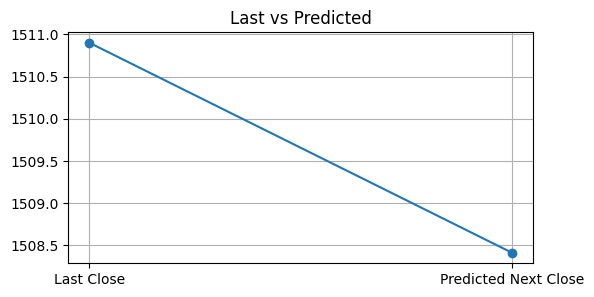

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

pred = pd.read_csv("prediction_next_close.csv")["prediction"].iloc[0]
df = pd.read_csv("reliance.csv", parse_dates=["Date"] if "Date" in pd.read_csv("reliance.csv", nrows=0).columns else None)
last_close = df["Close"].iloc[-1]

print(f"Last actual Close: {last_close}")
print(f"Predicted next Close: {pred}")

# simple plot
plt.figure(figsize=(6,3))
plt.plot([0,1],[last_close,pred], marker='o')
plt.xticks([0,1],["Last Close","Predicted Next Close"])
plt.title("Last vs Predicted")
plt.grid(True)
plt.show()


In [8]:
# Fast one-shot predictions (use saved model and predictors to create preds for every row)
import os, glob, joblib, json, pandas as pd, numpy as np

model_folder = "models/next_close"
feats_path = "reliance_features.csv"   # must be the engineered features file
out_path = os.path.join(model_folder, "predictions_modelwide_next_close.csv")

# load predictor order saved by training
pred_json = next(iter(glob.glob(os.path.join(model_folder, "*_predictors.json"))), None)
if pred_json is None:
    raise SystemExit("No predictors JSON found in model folder. Run training or feature_engineering to create features and predictors JSON.")

with open(pred_json) as f:
    predictors = json.load(f)
print("Predictors count:", len(predictors), "sample:", predictors[:8])

# load engineered features
if not os.path.exists(feats_path):
    raise SystemExit(f"Engineered features not found: {feats_path}. Run feature_engineering.py first.")
feats = pd.read_csv(feats_path, parse_dates=["Date"] if "Date" in pd.read_csv(feats_path, nrows=0).columns else None)

missing = [c for c in predictors if c not in feats.columns]
if missing:
    raise SystemExit(f"Missing predictor columns in {feats_path}: {missing[:10]} ... (create these first)")

X = feats[predictors].values

# scale if scaler present
scaler_file = next(iter(glob.glob(os.path.join(model_folder, "*_scaler.joblib"))), None)
if scaler_file:
    scaler = joblib.load(scaler_file)
    Xs = scaler.transform(X)
    print("Loaded scaler:", scaler_file)
else:
    Xs = X
    print("No scaler found; using raw features.")

# load model (xgboost booster preferred)
xgb_file = next(iter(glob.glob(os.path.join(model_folder, "*_xgb.json"))), None)
if xgb_file:
    import xgboost as xgb
    booster = xgb.Booster()
    booster.load_model(xgb_file)
    dmat = xgb.DMatrix(Xs)
    preds = booster.predict(dmat)
    print("Used xgboost booster:", xgb_file)
else:
    job_model = next(iter(glob.glob(os.path.join(model_folder, "*.joblib"))), None)
    if not job_model:
        raise SystemExit("No model file found in model folder.")
    mdl = joblib.load(job_model)
    preds = mdl.predict(Xs)
    print("Used joblib model:", job_model)

out_df = pd.DataFrame({"Date": feats["Date"] if "Date" in feats.columns else np.arange(len(feats)), "prediction": preds})
os.makedirs(model_folder, exist_ok=True)
out_df.to_csv(out_path, index=False)
print("Saved one-shot predictions to:", out_path)
display(out_df.head())


Predictors count: 31 sample: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'next_open', 'Open_lag_1']
Loaded scaler: models/next_close\next_close_xgb_scaler.joblib
Used xgboost booster: models/next_close\next_close_xgb_xgb.json
Saved one-shot predictions to: models/next_close\predictions_modelwide_next_close.csv


,Date,prediction
0,2022-01-10,1133.087280
1,2022-01-11,1162.496826
2,2022-01-12,1170.083374
3,2022-01-13,1171.832886
4,2022-01-14,1177.316772
